# Step 1 : Loading the weather data

In [1]:
import pandas as pd
import glob
import os

def load_weather_data(file_pattern):
    """
    Reads multiple csv.gz files and combines them into a single DataFrame.
    """
    file_list = glob.glob(file_pattern)
    
    if not file_list:
        print("No files found matching the pattern.")
        return None

    print(f"Found {len(file_list)} files. Beginning processing...")

    dataframes = []

    for file in file_list:
        try:
            df = pd.read_csv(
                file, 
                compression='gzip', 
                sep=';',  
                encoding='utf-8', 
                low_memory=False,
                usecols=['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'TNTXM']
            )
            
            dataframes.append(df)
            print(f"Successfully loaded: {file}")
            
        except Exception as e:
            print(f"Error loading {file}: {e}")

    
    print("Concatenating files...")
    full_df = pd.concat(dataframes, ignore_index=True)
    print(f"Done! Final shape: {full_df.shape}")
    return full_df

pattern = "./data/Q_*_previous-*-*_RR-T-Vent.csv.gz"
weather_df = load_weather_data(pattern)

# Preview the data
weather_df.head()

Found 6 files. Beginning processing...
Successfully loaded: ./data\Q_18_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_28_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_36_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_37_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_41_previous-1950-2023_RR-T-Vent.csv.gz
Successfully loaded: ./data\Q_45_previous-1950-2023_RR-T-Vent.csv.gz
Concatenating files...
Done! Final shape: (5650137, 8)


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,TNTXM
0,18003002,LES AIX,47.216667,2.55,182,19500101,0.0,NaN
1,18003002,LES AIX,47.216667,2.55,182,19500102,1.6,NaN
2,18003002,LES AIX,47.216667,2.55,182,19500103,5.4,NaN
3,18003002,LES AIX,47.216667,2.55,182,19500104,2.0,NaN
4,18003002,LES AIX,47.216667,2.55,182,19500105,1.9,NaN


In [2]:

distinct_postes = weather_df['NUM_POSTE'].nunique()
print(f"Number of distinct NUM_POSTE: {distinct_postes}")

    
missing_rows_count = weather_df.isnull().any(axis=1).sum()
N = weather_df.shape[0]
print(f"Number of lines with at least one missing value: {missing_rows_count} ({100*missing_rows_count/N:.0f} %)")

Number of distinct NUM_POSTE: 468
Number of lines with at least one missing value: 3239729 (57 %)


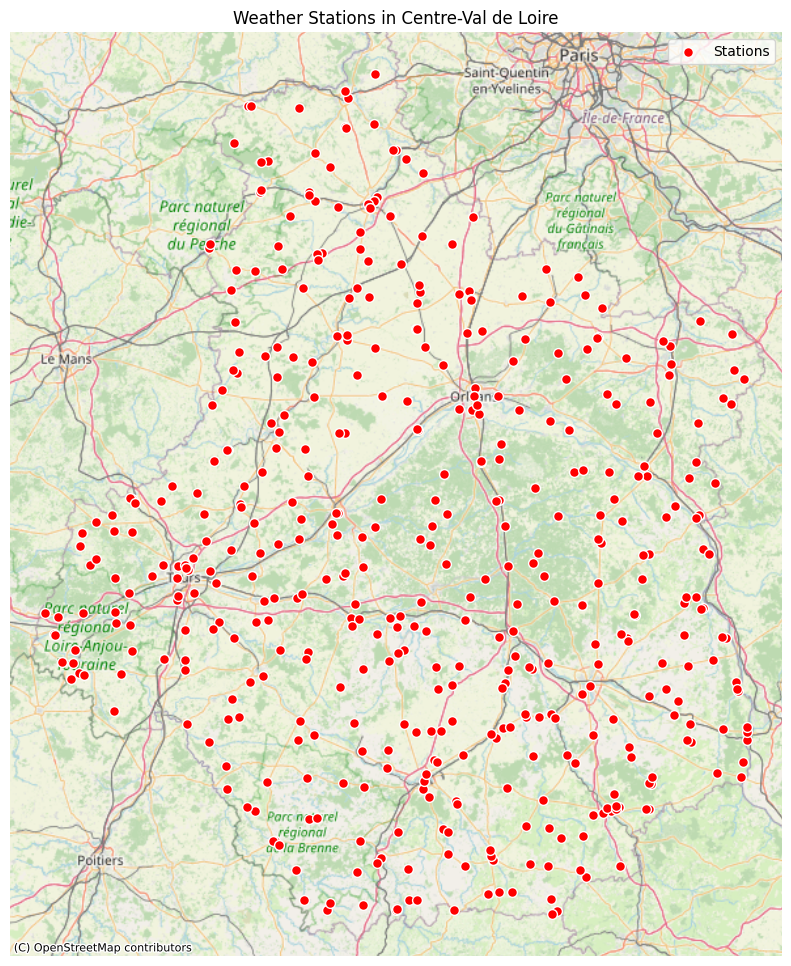

In [3]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Extract unique stations
stations = weather_df[['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON']].drop_duplicates()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    stations, 
    geometry=gpd.points_from_xy(stations.LON, stations.LAT), 
    crs="EPSG:4326"
)

# Plot
gdf_web = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf_web.plot(ax=ax, color='red', markersize=50, edgecolor='white', label='Stations')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off() # Hide axis numbers for a cleaner map look
plt.title("Weather Stations in Centre-Val de Loire")
plt.legend()
plt.show()

# Step 2 : Filling missing values

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import pygam
from scipy.interpolate import griddata

# --- 1. SETUP & GAM TRAINING (Your Code) ---
# Assuming 'weather_df' is loaded. If not, load it before this cell.
# weather_df = pd.read_csv(...) 

weather_df['DATE_OBJ'] = pd.to_datetime(weather_df['AAAAMMJJ'], format='%Y%m%d')
weather_df['day_of_year'] = weather_df['DATE_OBJ'].dt.dayofyear
weather_df['year'] = weather_df['DATE_OBJ'].dt.year

train_df = weather_df.dropna(subset=['TNTXM'])
# missing_df = weather_df[weather_df['TNTXM'].isnull()] # Not needed for this specific viz

X_train = train_df[['LON', 'LAT', 'ALTI', 'day_of_year', 'year']].values
y_train = train_df['TNTXM'].values

print("Fitting GAM with your parameters...")
gam = pygam.LinearGAM(
    pygam.te(0, 1, n_splines=4) +  # LON, LAT
    pygam.s(2, n_splines=4) +      # Elevation
    pygam.s(3, basis='cp', n_splines=4) + # Seasonality
    pygam.s(4, n_splines=9)        # Year
)
gam.fit(X_train, y_train)
print("GAM Fit complete.")

Fitting GAM with your parameters...
GAM Fit complete.


Generating spatial grid...


C:\Users\debat\AppData\Local\Temp\ipykernel_9052\540315087.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = gdf_stations.unary_union.convex_hull


Plotting map for 2023-07-15...
Calculating long-term averages (1950-2023)...


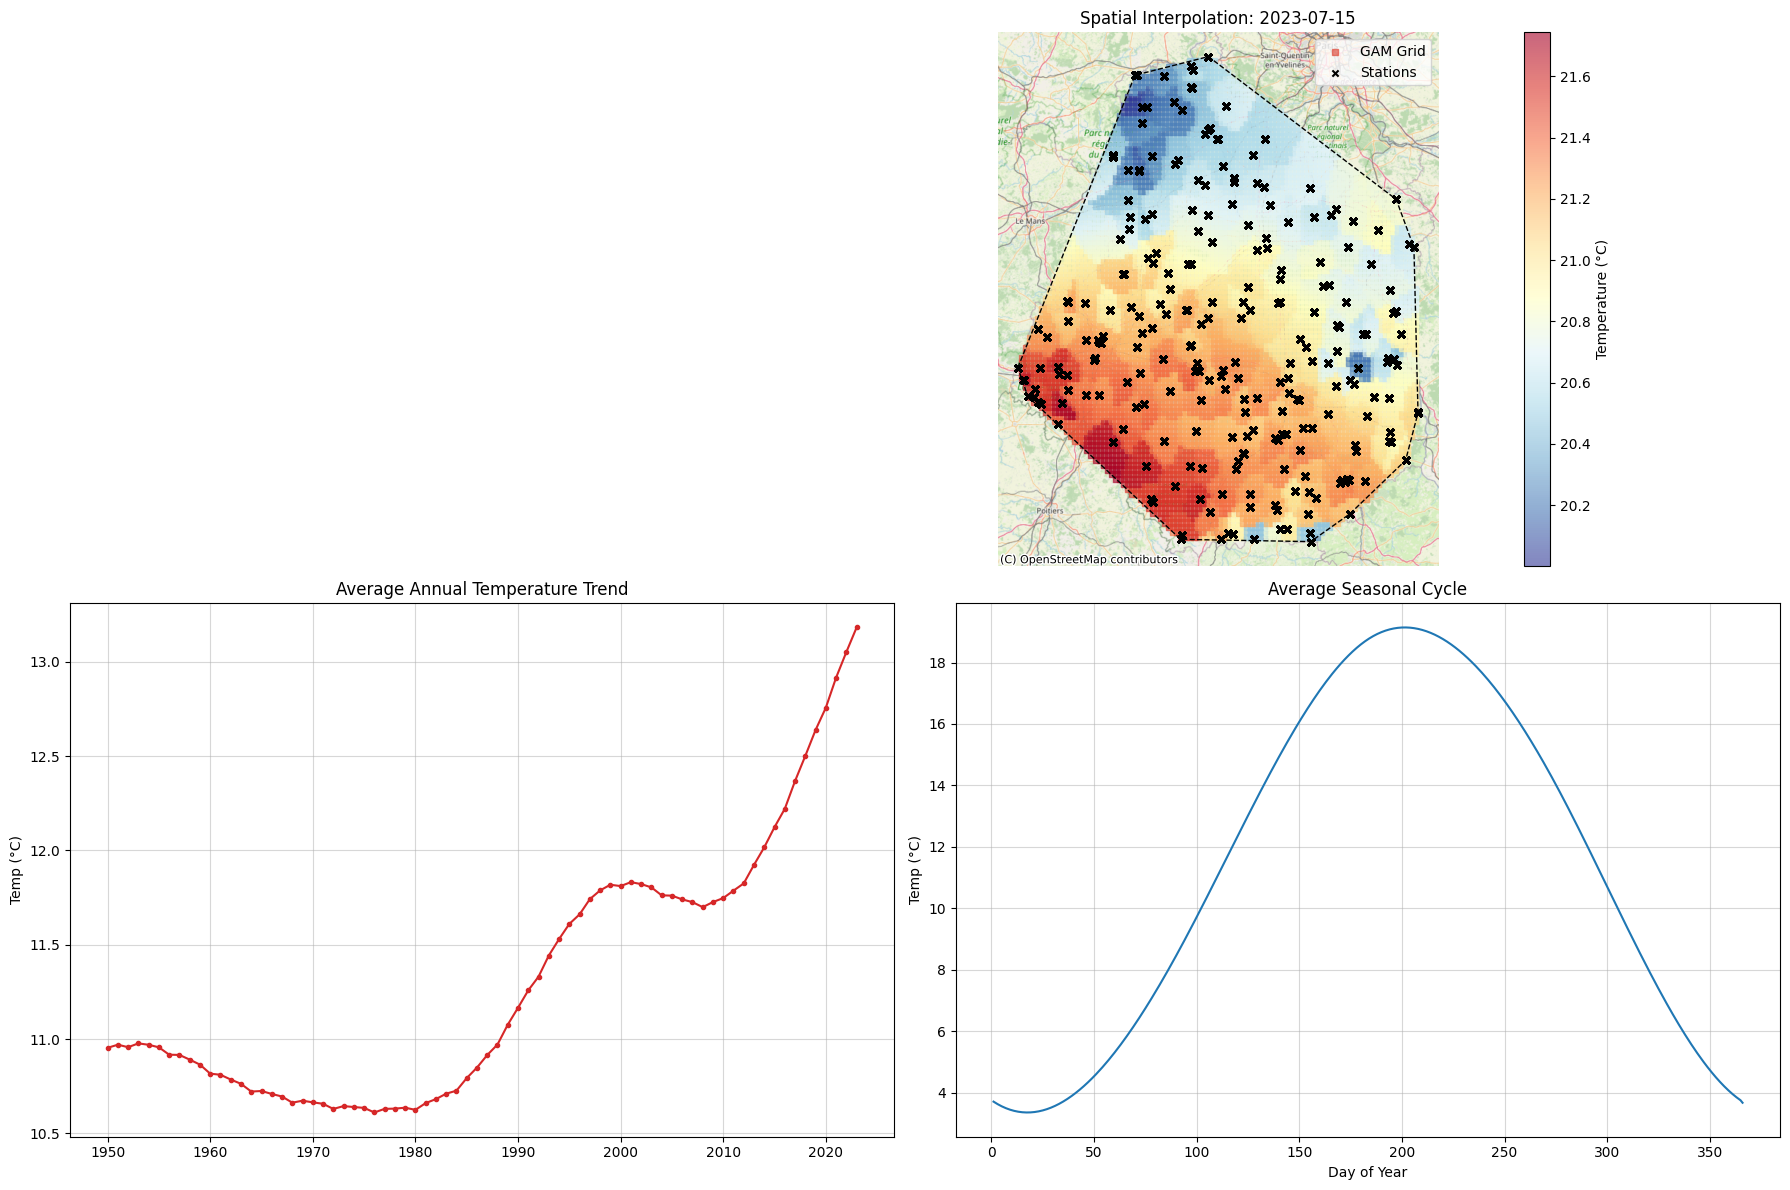

In [11]:
# --- 2. GRID GENERATION & CONVEX HULL FILTERING ---
print("Generating spatial grid...")

# Define bounds
x_min, x_max = weather_df['LON'].min(), weather_df['LON'].max()
y_min, y_max = weather_df['LAT'].min(), weather_df['LAT'].max()

# Create meshgrid (100x100 resolution)
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, 100),
    np.linspace(y_min, y_max, 100)
)
flat_lon = grid_x.ravel()
flat_lat = grid_y.ravel()

# Interpolate Elevation (Nearest Neighbor from stations)
known_points = train_df[['LON', 'LAT']].values
known_alti = train_df['ALTI'].values
grid_alti = griddata(known_points, known_alti, (flat_lon, flat_lat), method='nearest')

# Create temporary GeoDataFrame to filter by Convex Hull
pred_df = pd.DataFrame({'LON': flat_lon, 'LAT': flat_lat, 'ALTI': grid_alti})
gdf_grid = gpd.GeoDataFrame(pred_df, geometry=gpd.points_from_xy(pred_df.LON, pred_df.LAT), crs="EPSG:4326")
gdf_stations = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.LON, train_df.LAT), crs="EPSG:4326")

# Filter points outside the station hull
hull = gdf_stations.unary_union.convex_hull
mask_inside = gdf_grid.within(hull)
valid_grid = pred_df.loc[mask_inside].copy() # This is our clean grid (Space & Elev)

# --- 3. PLOT 1: SPATIAL MAP (Specific Date) ---
target_date_str = "2023-07-15" # Change as needed
target_date = pd.to_datetime(target_date_str)
print(f"Plotting map for {target_date_str}...")

# Prepare X for grid prediction
n_grid = len(valid_grid)
X_grid_map = np.column_stack((
    valid_grid['LON'], valid_grid['LAT'], valid_grid['ALTI'], 
    np.full(n_grid, target_date.dayofyear), 
    np.full(n_grid, target_date.year)
))

# Predict
valid_grid['TEMP_PRED'] = gam.predict(X_grid_map)

# Visualization
gdf_viz = gpd.GeoDataFrame(valid_grid, geometry=gpd.points_from_xy(valid_grid.LON, valid_grid.LAT), crs="EPSG:4326")
gdf_viz = gdf_viz.to_crs(epsg=3857) # Web Mercator
gdf_stations_web = gdf_stations.to_crs(epsg=3857)
hull_web = gpd.GeoSeries([hull], crs="EPSG:4326").to_crs(epsg=3857)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# Subplot 1: Map
ax1 = fig.add_subplot(gs[0, :]) # Top row, full width
sc = ax1.scatter(gdf_viz.geometry.x, gdf_viz.geometry.y, c=gdf_viz['TEMP_PRED'], 
                 cmap='RdYlBu_r', s=20, marker='s', alpha=0.6, label='GAM Grid')
hull_web.plot(ax=ax1, facecolor='none', edgecolor='black', linestyle='--')
ax1.scatter(gdf_stations_web.geometry.x, gdf_stations_web.geometry.y, c='k', s=20, marker='x', label='Stations')
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
plt.colorbar(sc, ax=ax1, label='Temperature (°C)')
ax1.set_axis_off()
ax1.set_title(f"Spatial Interpolation: {target_date_str}")
ax1.legend()

# --- 4. CALCULATION: LONG-TERM REGIONAL AVERAGE ---
print("Calculating long-term averages (1950-2023)...")

# OPTIMIZATION TRICK:
# Reg_Mean(t) = Mean(Space_Grid_Ref) + [Time_Pred(point, t) - Time_Pred(point, Ref)]

# A. Mean of Spatial Grid at Reference Time
ref_d, ref_y = 1, 2000
X_ref_grid = np.column_stack((
    valid_grid['LON'], valid_grid['LAT'], valid_grid['ALTI'], 
    np.full(n_grid, ref_d), np.full(n_grid, ref_y)
))
mean_spatial_ref = np.mean(gam.predict(X_ref_grid))

# B. Time Series for Single Point
loc = valid_grid.iloc[0]
dates = pd.date_range('1950-01-01', '2023-12-31')
X_ts = np.column_stack((
    np.full(len(dates), loc['LON']), np.full(len(dates), loc['LAT']), np.full(len(dates), loc['ALTI']),
    dates.dayofyear, dates.year
))
ts_pred = gam.predict(X_ts)

# C. Calculate Offset
X_loc_ref = np.array([[loc['LON'], loc['LAT'], loc['ALTI'], ref_d, ref_y]])
loc_ref_val = gam.predict(X_loc_ref)[0]
offset = mean_spatial_ref - loc_ref_val

# D. Final Series
regional_means = ts_pred + offset
res_df = pd.DataFrame({'Year': dates.year, 'Day': dates.dayofyear, 'Temp': regional_means})

# --- 5. PLOTS 2 & 3: TIME SERIES ---

# Subplot 2: Annual Trend
ax2 = fig.add_subplot(gs[1, 0])
annual = res_df.groupby('Year')['Temp'].mean()
ax2.plot(annual.index, annual.values, color='tab:red', marker='.')
ax2.set_title("Average Annual Temperature Trend")
ax2.set_ylabel("Temp (°C)")
ax2.grid(True, alpha=0.5)

# Subplot 3: Seasonal Cycle
ax3 = fig.add_subplot(gs[1, 1])
seasonal = res_df.groupby('Day')['Temp'].mean()
ax3.plot(seasonal.index, seasonal.values, color='tab:blue')
ax3.set_title("Average Seasonal Cycle")
ax3.set_xlabel("Day of Year")
ax3.set_ylabel("Temp (°C)")
ax3.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()